# A/B Testing Course

## Lesson 5. Bootstrap & Confidence Intervals

### Homework

#### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm

#### Import Data

In [3]:
df_exp_users = pd.read_csv('experiment_users.csv')

In [4]:
df_web_logs = pd.read_csv('2022-04-13T12_df_web_logs.csv')

#### Data Description

df_exp_users - users split in the experiment:
- user_id - user identifier;
- pilot - test group flag.

df_web_logs - web logs information:
- user_id - user identifier;
- page - visited page;
- date - date and time of a page visit;
- load_time - page load time.

#### Checking Data

In [5]:
df_exp_users.head()

,user_id,pilot
0,c36b2e,0
1,20336e,0
2,034652,0
3,e98e3b,0
4,3f1105,0


In [6]:
df_exp_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5456 non-null   object
 1   pilot    5456 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 85.4+ KB


In [7]:
df_web_logs.head()

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


In [8]:
df_web_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401709 entries, 0 to 2401708
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   page       object 
 2   date       object 
 3   load_time  float64
dtypes: float64(1), object(3)
memory usage: 73.3+ MB


In [9]:
df_web_logs.load_time.isna().sum()

0

#### Task 1. 

Experiment was held from 2022-04-05 to 2022-04-12.  
Check the significance of differences of other quantiles: 0.7; 0.74; 0.78; 0.82; 0.86; 0.90; 0.95; 0.99; 0.999; 0.9999  
When checking, use a normal confidence interval.

In [10]:
# filtering data by date
logs_filt = df_web_logs[(df_web_logs['date'] >= '2022-04-05') & \
                      (df_web_logs['date'] < '2022-04-12')]

In [11]:
# merging web logs and experiment groups data
df_groups = pd.merge(logs_filt, df_exp_users, how='inner', on='user_id')

In [12]:
# control and test groups data
load_time_a = df_groups[df_groups['pilot'] == 0]['load_time'].values
load_time_b = df_groups[df_groups['pilot'] == 1]['load_time'].values

In [13]:
# function to get normal confidence interval with help of bootstrap
def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    c = norm.ppf(1 - alpha / 2)
    se = np.std(boot_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    return left, right

In [14]:
# function to run bootstrap
def bootstrap(group_a, group_b, quantile, iterations=1000):
    # helper function to get point estimate
    def get_point_estimate(a_group, b_group, quantile=0.95):
        return np.quantile(b_group, quantile) - np.quantile(a_group, quantile)
    
    # getting point estimate
    point_estimate = get_point_estimate(group_a, group_b, quantile=quantile)

    # bootstrapping data
    bs_point_estimates = []
    for _ in range(iterations):
        bs_a = np.random.choice(group_a, size=len(group_a), replace=True)
        bs_b = np.random.choice(group_b, size=len(group_b), replace=True)
        bs_point_estimate = get_point_estimate(bs_a, bs_b, quantile=quantile)
        bs_point_estimates.append(bs_point_estimate)
        
    return bs_point_estimates, point_estimate

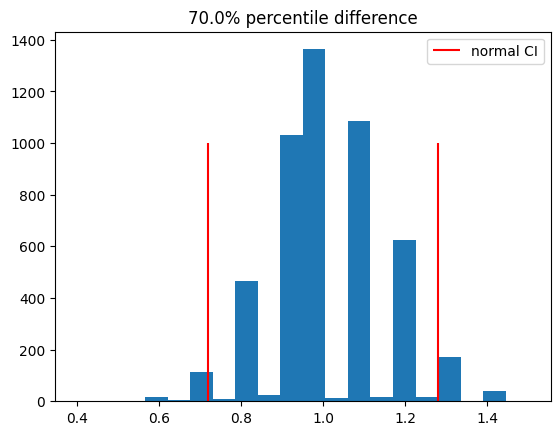

There is a significant difference!



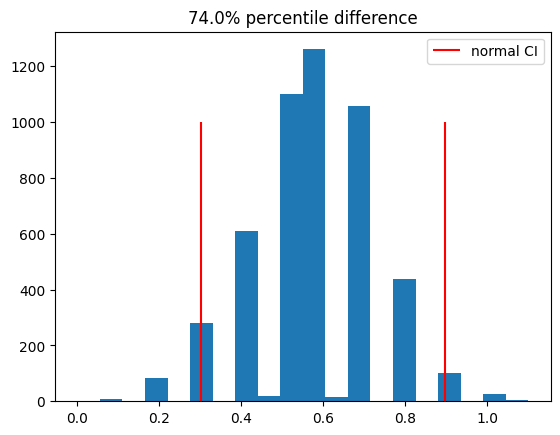

There is a significant difference!



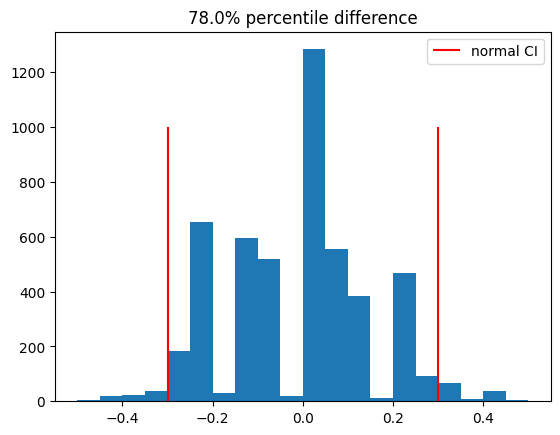

There is no significant effect here.



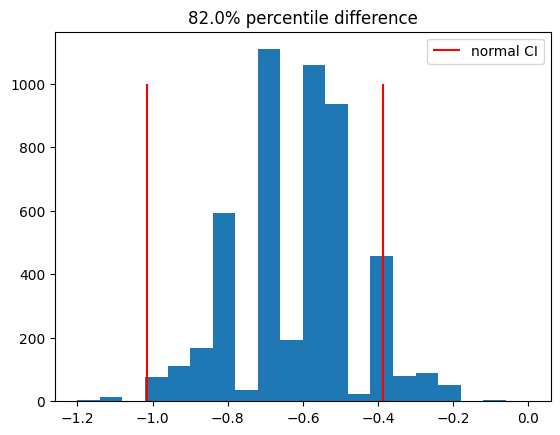

There is a significant difference!



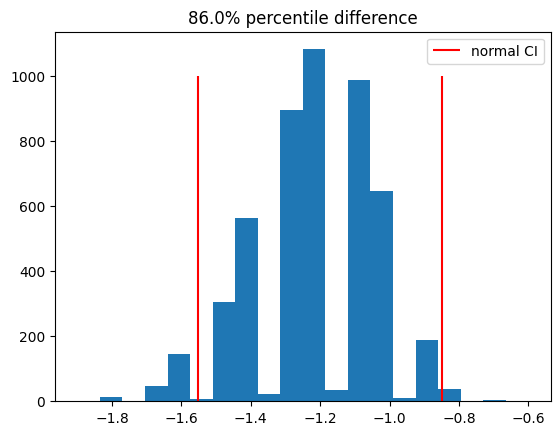

There is a significant difference!



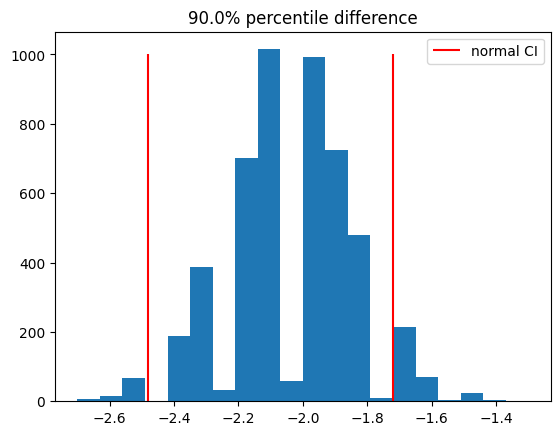

There is a significant difference!



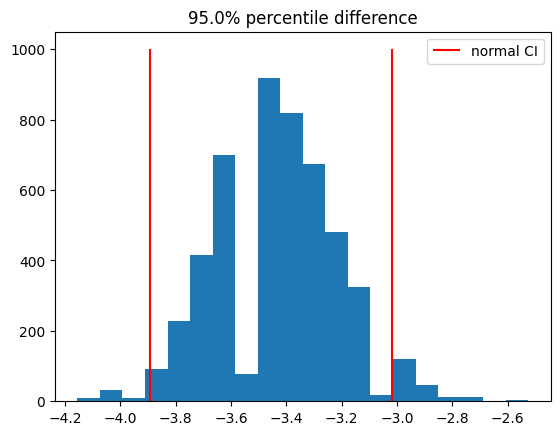

There is a significant difference!



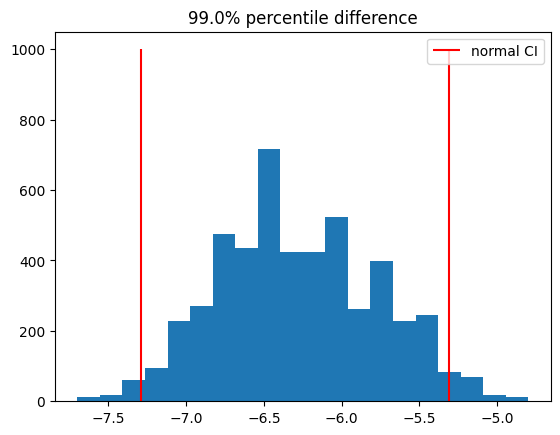

There is a significant difference!



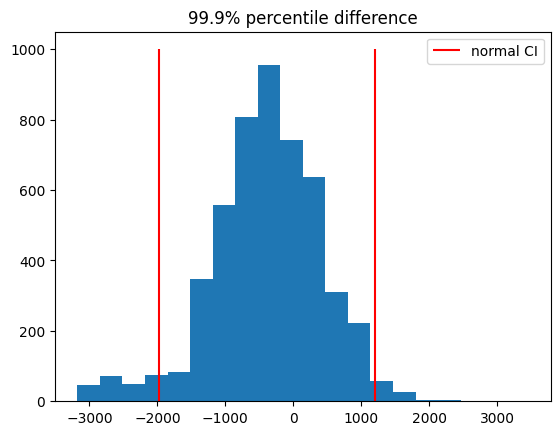

There is no significant effect here.



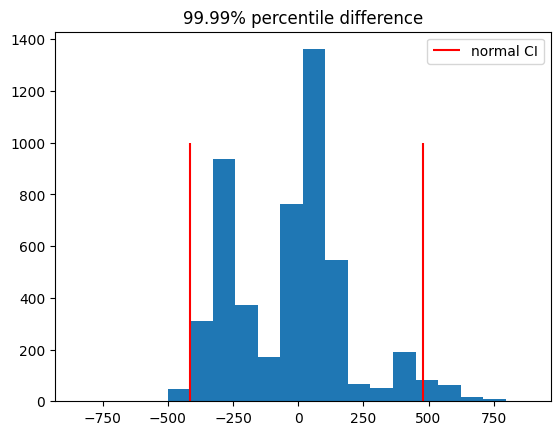

There is no significant effect here.



In [15]:
# lets check significance of difference for given percentiles
percentiles = [0.7, 0.74, 0.78, 0.82, 0.86, 0.90, 0.95, 0.99, 0.999, 0.9999]


for perc in percentiles:
    bs_data, pe = bootstrap(load_time_a, load_time_b, quantile=perc, iterations=5000)
    normal_ci = get_ci_bootstrap_normal(bs_data, pe)
    
    plt.title(f'{perc*100}% percentile difference')
    plt.hist(bs_data, bins=20);
    plt.vlines(normal_ci, 0, 1000, label='normal CI', color='red')
    plt.legend()
    plt.show()
    
    if normal_ci[0] > 0 or normal_ci[1] < 0:
        print('There is a significant difference!\n')
    else:
        print('There is no significant effect here.\n')

#### Task 2. 

In [16]:
import numpy as np
import pandas as pd
from pydantic import BaseModel
from scipy import stats


class Design(BaseModel):
    """Date class with description of experiment parameters.
    
    statistical_test - type of statistical test. ['ttest', 'bootstrap']
    effect - effect size in percentage
    alpha - significance level
    beta - allowable probability of type II error
    bootstrap_iter - number of bootstrap iterations
    bootstrap_ci_type - method of constructing a confidence interval. ['normal', 'percentile', 'pivotal']
    bootstrap_agg_func - experiment metric. ['mean', 'quantile 95']
    """
    statistical_test: str
    effect: float
    alpha: float = 0.05
    beta: float = 0.1
    bootstrap_iter: int = 1000
    bootstrap_ci_type: str
    bootstrap_agg_func: str


class ExperimentsService:

    def _generate_bootstrap_metrics(self, data_one, data_two, design):
        """Generates metric values obtained using bootstrap.
        
        :param data_one, data_two (np.array): metric values in the groups.
        :param design (Design): an object with data describing the experiment parameters.
        :return bootstrap_metrics, pe_metric:
            bootstrap_metrics (np.array) - test statistic values calculated on bootstrap subsamples
            pe_metric (float) - test statistic value calculated on the original data.
        """
        bootstrap_data_one = np.random.choice(data_one, (len(data_one), design.bootstrap_iter))
        bootstrap_data_two = np.random.choice(data_two, (len(data_two), design.bootstrap_iter))
        if design.bootstrap_agg_func == 'mean':
            bootstrap_metrics = bootstrap_data_two.mean(axis=0) - bootstrap_data_one.mean(axis=0)
            pe_metric = data_two.mean() - data_one.mean()
            return bootstrap_metrics, pe_metric
        elif design.bootstrap_agg_func == 'quantile 95':
            bootstrap_metrics = (
                np.quantile(bootstrap_data_two, 0.95, axis=0)
                - np.quantile(bootstrap_data_one, 0.95, axis=0)
            )
            pe_metric = np.quantile(data_two, 0.95) - np.quantile(data_one, 0.95)
            return bootstrap_metrics, pe_metric
        else:
            raise ValueError('Wrong value: design.bootstrap_agg_func')

    def _run_bootstrap(self, bootstrap_metrics, pe_metric, design):
        """Builds a confidence interval and tests for significance of differences using bootstrap.
        
        :param bootstrap_metrics (np.array): test statistic calculated on bootstrap samples.
        :param pe_metric (float): test statistic calculated on the original data.
        :return ci, pvalue:
            ci [float, float] - confidence interval boundaries.
            pvalue (float) - 0 if there is a statistically significant difference, otherwise 1.
                It is not trivial to compute the true p-value for an arbitrary bootstrap confidence interval. 
                Therefore, we will use the boundary values of 0 and 1.
        """
        # YOUR_CODE_HERE
        alpha = design.alpha   
        bootstrap_ci_type = design.bootstrap_ci_type 

        def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
            c = stats.norm.ppf(1 - alpha / 2)
            se = np.std(boot_metrics)
            left, right = pe_metric - c * se, pe_metric + c * se
            return left, right

        def get_ci_bootstrap_percentile(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
            left, right = np.quantile(boot_metrics, [alpha / 2, 1 - alpha / 2])
            return left, right

        def get_ci_bootstrap_pivotal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
            right, left = 2 * pe_metric - np.quantile(boot_metrics, [alpha / 2, 1 - alpha / 2])
            return left, right
        
        if bootstrap_ci_type == 'normal':
            ci = get_ci_bootstrap_normal(bootstrap_metrics, pe_metric, alpha)
        elif bootstrap_ci_type == 'percentile':
            ci = get_ci_bootstrap_percentile(bootstrap_metrics, pe_metric, alpha)
        elif bootstrap_ci_type == 'pivotal':
            ci = get_ci_bootstrap_pivotal(bootstrap_metrics, pe_metric, alpha)
        
        p_value = 0 if ci[0] > 0 or ci[1] < 0 else 1
        
        return ci, p_value


    def get_pvalue(self, metrics_a_group, metrics_b_group, design):
        """Applies a statistical test and returns the p-value.
        
        :param metrics_a_group (np.array): array of metric values for group A
        :param metrics_b_group (np.array): array of metric values for group B
        :param design (Design): object with experiment parameters description
        :return (float): p-value
        """
        if design.statistical_test == 'ttest':
            _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
            return pvalue
        elif design.statistical_test == 'bootstrap':
            bootstrap_metrics, pe_metric = self._generate_bootstrap_metrics(metrics_a_group, metrics_b_group, design)
            _, pvalue = self._run_bootstrap(bootstrap_metrics, pe_metric, design)
        else:
            raise ValueError('Wrong design.statistical_test')


if __name__ == '__main__':
    bootstrap_metrics = np.arange(-490, 510)
    pe_metric = 5.
    design = Design(
        statistical_test='bootstrap',
        effect=5,
        bootstrap_ci_type='normal',
        bootstrap_agg_func='mean'
    )
    ideal_ci = (-560.79258, 570.79258)
    ideal_pvalue = 1.

    experiments_service = ExperimentsService()
    ci, pvalue = experiments_service._run_bootstrap(bootstrap_metrics, pe_metric, design)
    np.testing.assert_almost_equal(ideal_ci, ci, decimal=4, err_msg='Wrong confidence interval!')
    assert ideal_pvalue == pvalue, 'Wrong pvalue!'
    print('simple test passed')

simple test passed
